In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

from tensorflow.keras import Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, LeakyReLU, Bidirectional, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive


In [3]:
train_data = h5py.File(r'/content/drive/MyDrive/Data/Single Factor Generated Data/MA0035_4_m3_train.h5', 'r')
test_data = h5py.File(r'/content/drive/MyDrive/Data/Single Factor Generated Data/MA0035_4_m3_test.h5', 'r')  

train_data_binlabels, train_data_features = np.array(train_data['binlabels']), np.array(train_data['data'])
test_data_binlabels, test_data_features = np.array(test_data['binlabels']), np.array(test_data['data'])

train_data_features = np.array([i.T for i in train_data_features])
test_data_features = np.array([i.T for i in test_data_features])

train_data.close()
test_data.close()

In [4]:
def plot_loss_and_AUC(model_history):
  fig, ax = plt.subplots(ncols=2, figsize=(14, 5))

  ax[0].plot(model_history.history["loss"])
  ax[0].plot(model_history.history["val_loss"])
  ax[0].title.set_text('model train loss vs validation loss')
  ax[0].set(xlabel="loss", ylabel="epoch")
  ax[0].legend(['train', 'validation'], loc='upper right')

  ax[1].plot(model_history.history["AUC"])
  ax[1].plot(model_history.history["val_AUC"])
  ax[1].title.set_text('model train accuracy vs validation accuracy')
  ax[1].set(xlabel="accuracy", ylabel="epoch")
  ax[1].legend(['train', 'validation'], loc='lower right')

  plt.show()

In [8]:
clear_session()

input_layer = Input(shape = (1000, 4))

hidden_layer = Conv1D(filters = 16, kernel_size = 10, padding = "same", activation = LeakyReLU(alpha=0))(input_layer)
hidden_layer = MaxPooling1D(pool_size = 4, strides = 4)(hidden_layer)
hidden_layer = Conv1D(filters = 32, kernel_size = 4, padding = "same", activation = LeakyReLU(alpha=0))(hidden_layer)
hidden_layer = MaxPooling1D(pool_size = 4, strides = 4)(hidden_layer)
hidden_layer = Bidirectional(LSTM(units = 32))(hidden_layer)
hidden_layer = Dense(units = 32, activation = LeakyReLU())(hidden_layer)
hidden_layer = Dropout(0.1)(hidden_layer)

output = Dense(1, activation = "sigmoid")(hidden_layer)

single_class_model = Model(inputs = input_layer, outputs=output)
 
single_class_model.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(beta_1 = 0.95),
    metrics = [AUC(name = "AUC")]
)

single_class_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000, 4)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1000, 16)          656       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 16)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 32)           2080      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 62, 32)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640 

In [9]:
single_class_model_history = single_class_model.fit(train_data_features, train_data_binlabels, epochs = 20, batch_size = 1000, validation_split = 5e-2, shuffle = True)  

Epoch 1/20
95/95 [==============================] - 120s 889ms/step - loss: 0.6928 - AUC: 0.4994 - val_loss: 0.6926 - val_AUC: 0.4936
Epoch 2/20
95/95 [==============================] - 86s 906ms/step - loss: 0.6927 - AUC: 0.5004 - val_loss: 0.6924 - val_AUC: 0.5003
Epoch 3/20
95/95 [==============================] - 85s 892ms/step - loss: 0.6924 - AUC: 0.5056 - val_loss: 0.6925 - val_AUC: 0.4945
Epoch 4/20
95/95 [==============================] - 83s 873ms/step - loss: 0.6923 - AUC: 0.5077 - val_loss: 0.6925 - val_AUC: 0.4945
Epoch 5/20
95/95 [==============================] - 81s 856ms/step - loss: 0.6922 - AUC: 0.5135 - val_loss: 0.6925 - val_AUC: 0.5013
Epoch 6/20
95/95 [==============================] - 82s 867ms/step - loss: 0.6917 - AUC: 0.5215 - val_loss: 0.6921 - val_AUC: 0.5162
Epoch 7/20
95/95 [==============================] - 85s 897ms/step - loss: 0.6904 - AUC: 0.5363 - val_loss: 0.6905 - val_AUC: 0.5540
Epoch 8/20
95/95 [==============================] - 83s 878ms/step -

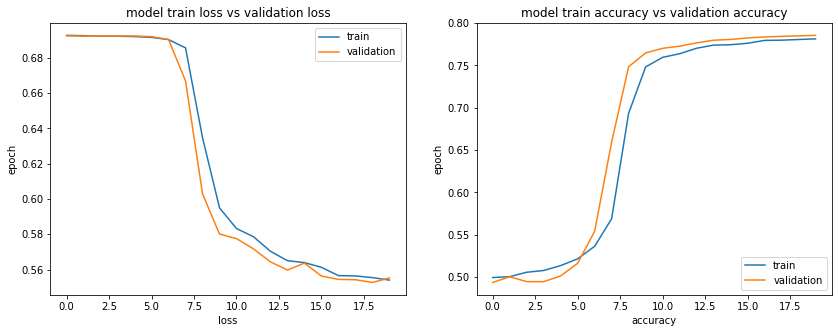



313/313 [==============================] - 5s 16ms/step - loss: 0.5322 - AUC: 0.8052


[0.532249927520752, 0.805203914642334]

In [11]:
plot_loss_and_AUC(single_class_model_history)
print("\n")
single_class_model.evaluate(test_data_features, test_data_binlabels)

In [12]:
single_class_model.save('/content/drive/MyDrive/Data/convrnn_binary_classification.h5')